In [1]:
import torch 
torch.set_default_dtype(torch.float64)

import matplotlib.pyplot as plt 
import numpy as np
import scipy 
from scipy.special import roots_legendre, factorial
from functools import partial
from einops import repeat

In [2]:
def ReLU2(x):
    return torch.maximum(torch.zeros_like(x), x) ** 2 

def dReLU2(x):
    return 2 * torch.maximum(torch.zeros_like(x), x) * (x>0)


# x = torch.linspace(-1,1,1000)
# x.requires_grad_()
# y = ReLU2(x)
# yx = torch.autograd.grad(y, x, grad_outputs=torch.ones_like(x), create_graph=True)[0]
# # yxx = torch.autograd.grad(yx, x, grad_outputs=torch.ones_like(x), create_graph=True)[0]

# yx_ = dReLU2(x)

# plt.plot(x.detach(), y.detach())
# plt.plot(x.detach(), yx.detach())
# plt.plot(x.detach(), yx_.detach())

# plt.plot(x.detach(), yxx.detach())

In [29]:
class EllipticOGA1d:
    def __init__(self, nNeuron, nqpts):
        self.nNeuron = nNeuron 
        self.nqpts = nqpts 

        # quad points
        xqd, wei = roots_legendre(nqpts)
        self.xqd = torch.from_numpy(xqd)
        self.wei = torch.from_numpy(wei)

        # rhs
        self.K = 1.0
        self.f = self.rhs()

        # sol
        self.uk = torch.zeros_like(self.f)
        self.duk = torch.zeros_like(self.f)
        self.uref = torch.cos(torch.pi * self.xqd)
        self.duref = -torch.pi * torch.sin(torch.pi * self.xqd)
        self.U = torch.zeros((nNeuron, nqpts))

        # neural network
        self.act = ReLU2
        self.dact = dReLU2
        self.W = torch.zeros((nNeuron, 1))
        self.Bias = torch.zeros((nNeuron, 1))

        # wb search
        # gd, gradient descent method, 
        # fdeu, finite difference Newton's method with explicit Euler scheme,
        # fdcd, finite difference Newton's method with central difference scheme.

        self.nw = 2 
        self.nb = 4001
        self.gdn = 100

        # alpha search 
        self.C = torch.zeros((nNeuron, nqpts))
        self.G = torch.zeros((nNeuron, nqpts))
        self.Gd = torch.zeros((nNeuron, nqpts))
        self.A = torch.zeros((nNeuron,1))

        # current neuron
        self.k = 0

    def rhs(self):
        return (torch.pi)**2 * torch.cos(torch.pi * self.xqd) + self.K*torch.cos(torch.pi * self.xqd)
    
    def error_display(self):
        errl2 = torch.sum((self.uk - self.uref) ** 2 * self.wei)**0.5
        errh1 = torch.sum(((self.duk - self.duref) ** 2 + (self.uk - self.uref) ** 2)* self.wei)**0.5
        print("{:}-th Neuron - L2 {:.5e} - H1 {:.5e}".format(self.k, errl2, errh1))

    def optimize(self):
        wk, bk = self.optimize_wb()
        self.W[self.k] = wk 
        self.Bias[self.k] = bk
        ak = self.optimize_alpha()
        self.A[:self.k+1] = ak.reshape(-1,1)

        self.forward()

        # if self.k in [2, 4, 8, 16, 32, 64, 128]:
        # if self.k % 10 == 0:
        #     self.error_display()
        self.U[self.k] = self.uk
        self.k += 1

    def forward(self):
        xqd = self.xqd.clone().requires_grad_()
        uk = torch.matmul(self.act(self.W * xqd + self.Bias).T, self.A).reshape(-1)
        duk = torch.autograd.grad(uk, xqd, grad_outputs=torch.ones_like(xqd), create_graph=True)[0]
        self.uk = uk.detach()
        self.duk = duk.detach()

    def initialguess_wb(self):
        W = torch.linspace(-1,1, self.nw)
        B = torch.linspace(-2,2, self.nb)
        ww, bb = torch.meshgrid(W, B)
        ws, bs = ww.reshape(-1), bb.reshape(-1)

        loss = []
        for w, b in zip(ws, bs):
            xqd = self.xqd.clone().requires_grad_()
            g = self.act(w*xqd + b)
            dg = torch.autograd.grad(g, xqd, grad_outputs=xqd, create_graph=True)[0]

            fg = self.f*g 
            ug = g*self.uk
            dudg = dg*self.duk

            rg = torch.sum((dudg + self.K*ug - fg)*self.wei)
            E = -0.5 * rg**2
            loss.append(E)

        idx = torch.argmin(torch.tensor(loss))
        wi, bi = ws[idx], bs[idx]
        print(min(loss))
        return wi, bi

    def gradientdescent_wb(self,w,b):
        dE = np.zeros(2)
        c    = w*self.xqd+b
        g    = self.act(c)
        dbg  = self.dact(c)
        dg   = dbg*w 
        dbdg = self.d2act(c)*w

        dudg = self.duk * dg 
        ug   = self.uk * g 
        fg   = self.f * g 

        rg = np.sum((dudg + self.K * ug - fg) * self.wei)
        E  = -0.5 * rg ** 2 

        rdbg = np.sum((self.duk*dbdg + self.K * self.uk * dbg - self.f * dbg) * self.wei)
        dE[1]   = -rg * rdbg
        return E, dE

    def optimize_wb(self):
        # initial guess by enumerate search
        wk, bk = self.initialguess_wb()
        print(wk, bk)
        # E0, dE0 = self.gradientdescent_wb(wk,bk)
        
        # eta = 1e-12
        # for i in range(self.gdn):
        #     E, dE = self.gradientdescent_wb(wk, bk)
        #     bk = bk - eta * dE[1] # gd update
        #     E1, dE1 = self.gradientdescent_wb(wk, bk)
        #     if np.linalg.norm(dE1, ord=np.inf) > np.linalg.norm(dE, ord=np.inf):
        #         # print("early stop at : {:}".format(i))
        #         break
        
        return wk, bk
    
    def optimize_alpha(self):
        xqd = self.xqd.clone().requires_grad_()
        wk = self.W[self.k]
        bk = self.Bias[self.k]
        gk = self.act(wk * xqd + bk)
        dgk = torch.autograd.grad(gk, xqd, grad_outputs=torch.ones_like(xqd), create_graph=True)[0]

        self.G[self.k] = gk 
        self.Gd[self.k] = dgk 

        gs = self.G[:self.k+1]
        gds = self.Gd[:self.k+1]

        gg = torch.matmul(gs, (gs*self.wei).T).T
        gdgd = torch.matmul(gds, (gds*self.wei).T).T
        fg = torch.sum(gs*self.f*self.wei, axis=1).T
        ak = torch.linalg.solve(self.K*gg+gdgd, fg)
        print('A : ', (self.K*gg+gdgd).detach().numpy())
        print('ak : ', ak.detach().numpy())
        return ak
    
    def train(self):
        for _ in range(self.nNeuron):
            self.optimize()

In [30]:
model = EllipticOGA1d(33, 6000)

In [31]:
model.train()

tensor(-9.7033, grad_fn=<MulBackward0>)
tensor(-1.) tensor(1.)
A :  [[17.06666667]]
ak :  [-0.25812215]


/tmp/ipykernel_2477054/2964314732.py:152: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1682343967769/work/aten/src/ATen/native/TensorShape.cpp:3571.)
  fg = torch.sum(gs*self.f*self.wei, axis=1).T


tensor(-9.6076, grad_fn=<MulBackward0>)
tensor(-1.) tensor(0.6970)
A :  [[17.06666667 12.48195096]
 [12.48195096  9.33079381]]
ak :  [ 3.67899472 -5.3832499 ]
tensor(-134.1052, grad_fn=<MulBackward0>)
tensor(-1.) tensor(2.)
A :  [[17.06666667 12.48195096 35.73333333]
 [12.48195096  9.33079381 25.00441213]
 [35.73333333 25.00441213 83.06666667]]
ak :  [ 7.72556419 -9.0431737  -0.65424803]
tensor(-95.7787, grad_fn=<MulBackward0>)
tensor(-1.) tensor(2.)


_LinAlgError: torch.linalg.solve: The solver failed because the input matrix is singular.

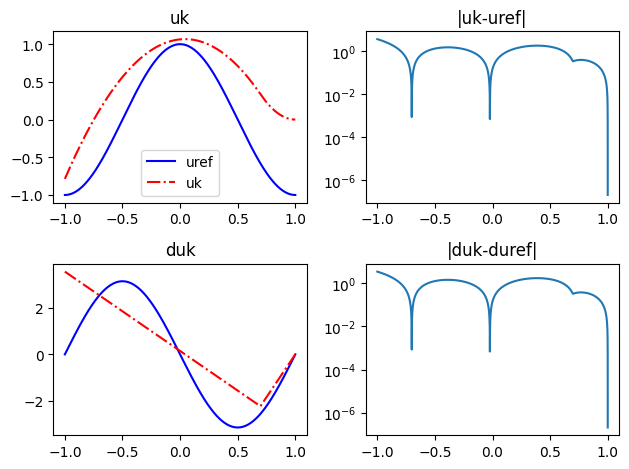

In [22]:
plt.subplot(221)
plt.plot(model.xqd, model.uref, '-b', label='uref')
plt.plot(model.xqd, model.uk, '-.r', label='uk')
plt.legend()
plt.title('uk')
plt.subplot(222)
plt.plot(model.xqd, np.abs(model.duk-model.duref))
plt.yscale('log')
plt.title('|uk-uref|')
plt.subplot(223)
plt.plot(model.xqd, model.duref, '-b', label='duref')
plt.plot(model.xqd, model.duk, '-.r', label='duk')
plt.title('duk')
plt.subplot(224)
plt.plot(model.xqd, np.abs(model.duk-model.duref))
plt.yscale('log')
plt.title('|duk-duref|')
plt.tight_layout()